In [2]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Implementing a MultiLayerPerceptron from first principles
---
This notebook implements a simple MLP model class using only numpy. Minibatch gradient descent using backpropogation is used for training (with fixed learning rate).

The gradient of the activation functions is hard coded (as opposed to using autograd aka autodiff implementation.

Only fully connected dense layers are supported.



## Plan

Implement a MultiLayerPerceptron class with the following structure

- Input arguments will be 
    * layers (first layer must be input aka passthrough), which is a list of ints, giving number of nuerons in each layer. Each layer (except for output) will include bias term automatically
    * activations, a list of functions which will be used as activations at each layer. Probably these functions will be methods of the class and specified as strings
- It will have private methods
    * forward - for making a pass through the network and computing all intermediate output
    * backward - computing gradients on backward pass through the network and updating weights and biases
    * update_mini_batch - updating weights and biases based on a minibatch
    * sigmoid, relu, softmax - activations and their derivatives (Jacobians). (Maybe put these in separate class?)
    * metrics for eval (maybe put these in separate class?)
    * loss functions: cross entropy, square error, absolute error (maybe put into separate class)
- It will have public methods
    * fit - perform mini-batch gradient descent to fit the model on a dataset
    * predict - pass input through network and generate prediction, no need to store intermediate results 
    
    
   


In [3]:
#------------------------------------
# Define MLP class ------------------
#------------------------------------

# here is the main class
# TODO: Currently backward only works on one instance at a time
# so don't get any matrix speedups when working on a minibatch
# need to go through and alter all grad functions so that they can
# handle mini-batch at a time

class MultiLayerPerceptron:
    """
    A simple implementation of multi layer perceptron
    """
    
    def __init__(self, layers, activations, loss):
        """
        Create instance of MLP model
        
        :param layers: A list of ints giving number of neurons in each layer. Note first entry of list should match size of expected input, and final layer is output
        :param activations: A list of strings specifying activation function to use in each layer. Must have length ``len(layers)-1`` since first layer is a passthrough. 
            allowed activations are: "relu", "logistic", "tanh", "softmax"
        :return: MultiLayerPerceptron
        """
        
        # weights is a list of numpy arrays. Note assumes W @ x, so W.shape[1] == number of nuerons in previous layer
        self.weights = [np.random.randn(this_layer_size, prev_layer_size) for this_layer_size, prev_layer_size in zip(layers[1:], layers[:-1])]
        
        # biases is a list of numpy arrays with single column
        self.biases = [np.random.randn(this_layer_size,1) for this_layer_size in layers[1:]]
        
        # activations is a list of callable functions specified by the strings provided
        self.activations = [getattr(self, '_' + x) for x in activations]
        
        # loss is a string specifying the name of loss function
        self.loss = getattr(self, '_' + loss)
    
    def predict(self, x):
        """
        Generate predictions with current weights on instance x
        """
        
        if x.ndim==1:
            # make column vectors so matrix multiplication works correctly
            x = x.reshape(-1,1)
        elif x.ndim==2 & (x.shape[0] == 1 or x.shape[1] ==1):
            # we either have a columns vector or row vector, lets ensure we have a column
            x = x.reshape(-1,1)
        elif x.ndim==2:
            # most likely we have observations in rows, we should transpose so below code runs
            x = x.T
        else:
            raise ValueError("Shape of input is not appropriate. See docstring.")
            
        for w, b, a in zip(self.weights, self.biases, self.activations):
            z = w @ x + b
            x = a(z, False)
        return x.T if x.shape[1] != 1 else x
    
    def stochastic_gradient_descent(self, x, y, batch_size=32, epochs=1, eta=0.1, n_print=100, valid_data=None, metric=None):
        """
        Implement mini-batch stochastic gradient descent to train the network
        """
        
        # parse optional arguments
        if valid_data is not None:
            x_valid, y_valid = valid_data[0], valid_data[1]
        if metric is not None:
            metric_fn = getattr(self, '_' + metric)
        
        # initialise output store
        history = {}
        history['loss'] = []
        if (metric is not None) & (valid_data is not None):
            history['metric'] = []
            
        for epoch in range(epochs):
            # shuffle the data
            idx = np.random.choice(np.arange(x.shape[0]), size=x.shape[0], replace=False)
            x_ = x[idx, :]
            y_ = y[idx, :]
            num_batches = np.int(x.shape[0] / batch_size)
            if num_batches > 100:
                for k in tqdm(range(num_batches)):
                    s = k * batch_size
                    e = (k+1) * batch_size
                    x_batch, y_batch = x_[s:e], y_[s:e]
                    weight_deltas, bias_deltas = [], []
                    for xi, yi in zip(x_batch, y_batch):
                        w, b = self._two_pass(xi, yi)
                        weight_deltas.append(w)
                        bias_deltas.append(b)
                    for i, (weight, bias) in enumerate(zip(self.weights, self.biases)):
                        for w_delta, b_delta in zip(weight_deltas, bias_deltas):
                            weight -= (eta/batch_size) * w_delta[i]
                            bias -= (eta/batch_size) * b_delta[i]    
            else:
                for k in range(num_batches):
                    s = k * batch_size
                    e = (k+1) * batch_size
                    x_batch, y_batch = x_[s:e], y_[s:e]
                    weight_deltas, bias_deltas = [], []
                    for xi, yi in zip(x_batch, y_batch):
                        w, b = self._two_pass(xi, yi)
                        weight_deltas.append(w)
                        bias_deltas.append(b)
                    for i, (weight, bias) in enumerate(zip(self.weights, self.biases)):
                        for w_delta, b_delta in zip(weight_deltas, bias_deltas):
                            weight -= (eta/batch_size) * w_delta[i]
                            bias -= (eta/batch_size) * b_delta[i]    
            
            y_hat = self.predict(x)
            curr_loss = self.loss(y, y_hat)
            history['loss'].append(curr_loss)
            if metric is not None:
                curr_metric = metric_fn(y, y_hat)
                history['metric'].append(curr_metric)
            if (epoch+1) % n_print == 0: print(f"SGD | Epochs completed: {epoch+1} | Training set loss: {curr_loss}")
        return history
                    
        
    def _forward(self, x: np.ndarray, y: np.ndarray):
        """
        forward pass through the network, record all intermediate computations for use later in backwards pass
        
        :param x: np.ndarray. If x.ndim == 1, then x is a vector with layers[0] elements. If x.ndim == 2, then shape should be n_observation, layers[0]. Ie. One row per obs.
        :param y: np.ndarray. x.ndim==1, then y.ndim==1 and has layers[-1] elements. If x.ndim == 2, then y.ndim == 2 and shape of y should be n_observation, layers[-1]. Ie. One row per obs.
        :return: Tuple of lists (layer_outputs, layer_grads)
        """
        
        assert y.ndim == x.ndim
        if x.ndim==1:
            # make column vectors so matrix multiplication works correctly
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)
        elif x.ndim==2 & (x.shape[0] == 1 or x.shape[1] ==1):
            # we either have a columns vector or row vector, lets ensure we have a column
            assert y.ndim == x.ndim
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)
        elif x.ndim==2 & np.min(x.shape) > 1:
            # assume we have observations in rows, we should transpose to below code runs
            x = x.T
            y = y.T
        else:
            raise ValueError("Shape of input is not appropriate. See docstring.")
            
        
        # store output from each layer in this object
        # no gradient at input
        layer_outputs = [x]
        grads = []
        
        # pass through all layers
        for w, b, a in zip(self.weights, self.biases, self.activations):
            z = w @ x + b
            x, g = a(z, True)
            layer_outputs.append(x)
            grads.append(g)
        
        # pass through the loss function, note we need to transpose again
        # since the loss function expects each observation is a row
        # TODO: Fix the shapes of everything so consistent, this is ugly and not readable
        l, g = self.loss(y.T, layer_outputs[-1].T, grad=True)
        layer_outputs.append(l)
        grads.append(g)
        
        return layer_outputs, grads
        
        
    def _backward(self, layer_outputs, grads):
        """
        Backward pass through the network, computing gradients at each layer and storing the update factor
        """    
        
        # initialise objects to store gradients for weights and biases
        weights_delta = [np.empty_like(w) for w in self.weights]
        biases_delta = [np.empty_like(b) for b in self.biases]
        
        # handle loss layer since special case
        loss, layer_outputs = layer_outputs[-1], layer_outputs[:-1]   # remove value of loss function from layer_outputs
        loss_grad, grads = grads[-1], grads[:-1]                      # remove gradient of loss from grads 
        
        # TODO: this is ugly and might break, must be a better way
        delta = loss_grad * grads[-1] if grads[-1].shape[1] == 1 \
                                      else grads[-1] @ loss_grad
        biases_delta[-1] = delta
        weights_delta[-1] = delta @ layer_outputs[-2].T
        
        # now step through remaining layers
        for i in range(2, len(layer_outputs)):
            delta = self.weights[-i+1].T @ delta * grads[-i]
            biases_delta[-i] = delta
            weights_delta[-i] = delta @ layer_outputs[-i-1].T 
            
            
        return weights_delta, biases_delta
        
    def _two_pass(self, x, y):
        """
        Forward pass then backward pass and return update deltas for all parameters
        """
        layer_outputs, grads = self._forward(x, y)
        weights_delta, biases_delta = self._backward(layer_outputs, grads)
        return weights_delta, biases_delta
    
    @staticmethod
    def _logistic(x: np.ndarray, grad: bool=False):
        """
        Compute logistic function for input x. Optionally compute gradient at x
        """
        ex = np.exp(-x)
        f = 1 / (1 + ex)
        if grad:
            g = ex / (1 + ex)**2
            return f, g
        else: 
            return f
    
    @staticmethod
    def _tanh(x: np.ndarray, grad: bool=False):
        """
        Compute hyperbolic tangent function for input x. Optionally compute gradient at x
        """
        ex = np.exp(2 * x)
        f = (ex - 1) / (ex + 1)
        if grad:
            g = 1 - f ** 2
            return f, g
        else:
            return f

    @staticmethod
    def _relu(x: np.ndarray, grad: bool=False):
        """
        Compute relu function at x. Optionally compute gradient at x
        """
        f = np.maximum(0, x)
        if grad:
            g = np.sign(x)
            return f, g
        else:
            return f
    
    @staticmethod
    def _linear(x, grad):
        """
        Compute linear function at x
        """
        if grad:
            return x, np.ones_like(x)
        else:
            return x
        
    
    @staticmethod
    def _softmax(x: np.ndarray, grad: bool=False):
        """
        Compute softmax for input x. Optionally compute grad (more accurately Jacobian). Note if input is N x 1, Jacobian is N x N matrix
        """
        ex = np.exp(x)
        f = ex / np.sum(ex, axis=0)
        if grad:
            g =  np.diagflat(f) - np.outer(f,f)
            return f, g
        else:
            return f
        
    
    @staticmethod
    def _categorical_cross_entropy(y: np.ndarray, y_hat: np.ndarray, grad=False, epsilon=1e-4):
        """
        Compute the cross entropy loss for set of predictions y_hat and labels y. Assumes y is one hot encoded, and y_hat contains class probs.
        Assumes y and y_hat have shape (n_observation, n_class)
        """
        y_hat_clipped = np.clip(y_hat, 0+epsilon, 1)
        l = np.mean(-np.log(y_hat_clipped[y==1]))
        if grad:
            g = np.mean(-1 * (1 / y_hat_clipped) * y, axis=0).reshape(-1,1)
            return l, g
        else:
            return l
        
    @staticmethod
    def _cross_entropy(y, y_hat, grad=False, epsilon=1e-4):
        """
        Compute cross entropy loss for binary response task
        """
        y_hat_clipped = np.clip(y_hat, 0+epsilon, 1-epsilon)
        l = - np.sum(y * np.log(y_hat_clipped) + (1 - y) * np.log(1 - y_hat_clipped))
        if grad:
            g = - (y * (1 / y_hat_clipped) - (1 - y) * (1 / (1 - y_hat_clipped))).reshape(-1,1)
            return l, g
        else:
            return l
    
    @staticmethod
    def _mean_square_error(y, y_hat, grad=False):
        """
        Compute mean square error loss, and optionally return gradient at y_hat
        """
        l = np.mean((y - y_hat) ** 2)
        if grad:
            g = (2 * (y_hat - y))
            return l, g
        else:
            return l
        
    @staticmethod
    def _mean_absolute_error(y, y_hat, grad=False):
        """
        Compute mean absolute error loss, and optionally return gradient at y_hat
        """
        l = np.mean(np.abs(y - y_hat))
        if grad:
            g = np.sign(y_hat - y).T
            return l, g
        else:
            return l
    
    @staticmethod
    def _accuracy(y, y_hat):
        """
        compute accuracy for classification task
        """
        if y_hat.ndim==1:
            a = np.mean(1.0 * (y == y_hat))
        elif y_hat.ndim==2:
            a = np.mean(1.0 * (np.argmax(y, axis=1) == np.argmax(y_hat, axis=1)))
        else:
            raise ValueError(f"y_hat and y are not appropriate shape. y_hat has shape: {y_hat.shape}, y has shape: {y.shape}")
        return a
        
        

## XOR Example
---
XOR is a simple boolean function which is not linearly separable, lets see if this MLP can solve it by using a hidden layer. Then solve the same problem using keras API with TensorFlow

In [4]:
# Set up the data, only four possible combinations
# note we represent the binary outcome as a 2 element row 

X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[1,0],[0,1],[0,1],[1,0]])

SGD | Epochs completed: 2000 | Training set loss: 0.009157973220704337
SGD | Epochs completed: 4000 | Training set loss: 0.004288617414710674
SGD | Epochs completed: 6000 | Training set loss: 0.0027834703882186045
SGD | Epochs completed: 8000 | Training set loss: 0.0020560046838282984
SGD | Epochs completed: 10000 | Training set loss: 0.0016283014460532052
[[0.99875634 0.00124366]
 [0.002124   0.997876  ]
 [0.00212375 0.99787625]
 [0.99898401 0.00101599]]


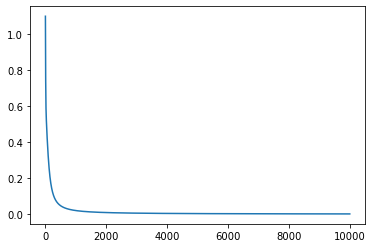

In [5]:
# initialise the MLP and train it, then plot the loss and look at predictions

m = MultiLayerPerceptron(layers=[2,2,2], activations=['tanh','softmax'], loss='categorical_cross_entropy')
history = m.stochastic_gradient_descent(X, Y, batch_size=4, epochs=10000, eta=0.1, n_print=2000)
plt.plot(history['loss'])
print(m.predict(X))

SGD | Epochs completed: 2000 | Training set loss: 0.4009245261316042
SGD | Epochs completed: 4000 | Training set loss: 0.331003680533727
SGD | Epochs completed: 6000 | Training set loss: 0.2982739525234347
SGD | Epochs completed: 8000 | Training set loss: 0.2826185102732576
SGD | Epochs completed: 10000 | Training set loss: 0.27407131455374933
[[0.03180999]
 [0.52268457]
 [0.97318056]
 [0.5603404 ]]


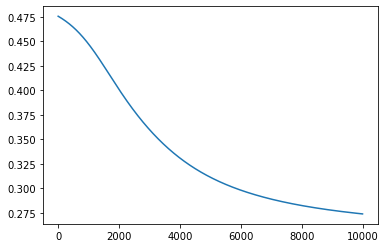

In [6]:
# we can try on the binary version of outputs to make sure that also works
# it seems like it struggles a lot more to solve with binary output like this

Y = np.array([[0],[1],[1],[0]])

m2 = MultiLayerPerceptron(layers=[2,2,1], activations=['tanh','logistic'], loss='mean_absolute_error')
history2 = m2.stochastic_gradient_descent(X, Y, batch_size=4, epochs=10000, eta=0.01, n_print=2000)
plt.plot(history2['loss'])
print(m2.predict(X))

SGD | Epochs completed: 2000 | Training set loss: 0.04140828521013422
SGD | Epochs completed: 4000 | Training set loss: 0.013738546359714377
SGD | Epochs completed: 6000 | Training set loss: 0.008181123711406509
SGD | Epochs completed: 8000 | Training set loss: 0.0058174622878632565
SGD | Epochs completed: 10000 | Training set loss: 0.0045113403879758675
[[9.47422812e-04]
 [9.99884230e-01]
 [9.97814898e-01]
 [1.25940512e-03]]


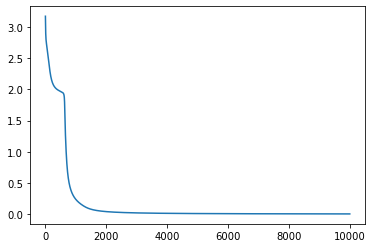

In [7]:
# can try the same thing with an extra layer - maybe the single output loses some flexibility

m3 = MultiLayerPerceptron(layers=[2,3,3,1], activations=['tanh','tanh','logistic'], loss='cross_entropy')
history3 = m3.stochastic_gradient_descent(X, Y, batch_size=4, epochs=10000, eta=0.1, n_print=2000)
plt.plot(history3['loss'])
print(m3.predict(X))

## Can do the same thing using TensorFlow API

Solve the same simple problem using TF api, see if behaviour is significantly different or not

In [8]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
tf.__version__

'2.2.0'

In [9]:
# first try with the original multicategorical output

Y = np.array([[1,0],[0,1],[0,1],[1,0]])

m = keras.models.Sequential()
m.add(keras.layers.InputLayer(input_shape=X[0].shape))
m.add(keras.layers.Dense(2, activation=keras.activations.tanh))
m.add(keras.layers.Dense(2, activation=keras.activations.softmax))
m.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.SGD(learning_rate=0.1))


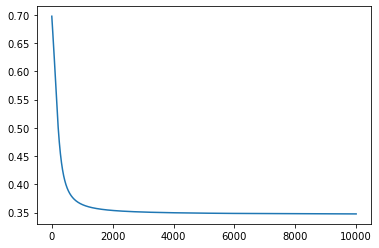

In [10]:
history = m.fit(X, Y, epochs=10000, batch_size=4, verbose=0)
plt.plot(history.history['loss'])

In [11]:
# seemed to solve problem well
m.predict(X)

array([[9.9914312e-01, 8.5688883e-04],
       [5.0056511e-01, 4.9943495e-01],
       [1.1122084e-03, 9.9888784e-01],
       [4.9925849e-01, 5.0074148e-01]], dtype=float32)

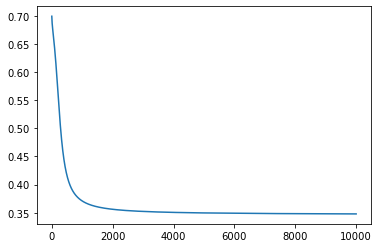

In [12]:
# what if we try on univarite binary outcomes

Y = np.array([[0],[1],[1],[0]])

m = keras.models.Sequential()
m.add(keras.layers.InputLayer(input_shape=X[0].shape))
m.add(keras.layers.Dense(2, activation=keras.activations.tanh))
m.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))
m.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.SGD(learning_rate=0.1))

history = m.fit(X,Y,epochs=10000,batch_size=4,verbose=0)
plt.plot(history.history['loss'])


In [13]:
# seems to have same issue as above - dooesn't solve correctly
m.predict(X)

array([[0.00148022],
       [0.99827284],
       [0.49938196],
       [0.5007494 ]], dtype=float32)

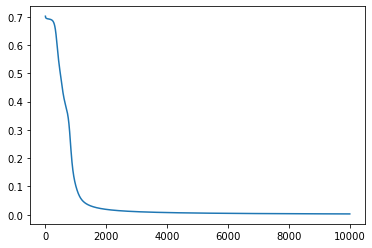

In [14]:
# try adding extra layer just as we did with custom implementation

m = keras.models.Sequential()
m.add(keras.layers.InputLayer(input_shape=X[0].shape))
m.add(keras.layers.Dense(3, activation=keras.activations.tanh))
m.add(keras.layers.Dense(3, activation=keras.activations.tanh))
m.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))
m.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.SGD(learning_rate=0.1))

history = m.fit(X, Y, epochs=10000, batch_size=4, verbose=0)
plt.plot(history.history['loss'])

In [15]:
# works very well
m.predict(X)

array([[4.9399405e-05],
       [9.9683940e-01],
       [9.9682963e-01],
       [4.2174757e-03]], dtype=float32)

## Try on more interesting data set
---

Load the fashion MNIST data set which is 60,000 28 x 28 greyscale pictures of clothing items, and associated class

We will try to solve the classification proble using both custom implementation and TF

In [16]:
# get data using keras utility
# this contains 60,000 28 x 28 ndarrays with values between 0 and 255, representing pixel intensities
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

# split train full into train and valid, and normalise so input is float between 0 and 1
x_valid, x_train = x_train_full[:5000] / 255.0, x_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# manually type out the class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [17]:
# first we will solve using keras

m = keras.models.Sequential()
m.add(keras.layers.Flatten(input_shape=x_train[0].shape))
m.add(keras.layers.Dense(300, activation=keras.activations.relu))
m.add(keras.layers.Dense(100, activation=keras.activations.relu))
m.add(keras.layers.Dense(len(class_names), activation=keras.activations.softmax))

m.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
    )


In [18]:
m.fit(x=x_train, y=y_train, epochs=1, validation_data=(x_valid, y_valid))


1719/1719 [==============================] - 33s 19ms/step - loss: 0.7299 - accuracy: 0.7627 - val_loss: 0.5484 - val_accuracy: 0.8050


In [19]:
# now try using custom implementation

y_train_onehot, y_valid_onehot = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_valid)
x_train_flat, x_valid_flat = x_train.reshape(x_train.shape[0],-1), x_valid.reshape(x_valid.shape[0],-1)

In [26]:
m2 = MultiLayerPerceptron(layers=[x_train[0].shape[0] ** 2, 300, 200, 100, len(class_names)],
                          activations=['tanh','tanh','tanh','softmax'],
                          loss='categorical_cross_entropy')

history2 = m2.stochastic_gradient_descent(x=x_train_flat, y=y_train_onehot,
                                          batch_size=128, epochs=30,
                                          n_print=1,
                                          valid_data=(x_valid_flat,y_valid_onehot),
                                         metric='accuracy')

100%|██████████| 429/429 [07:12<00:00,  1.01s/it]


SGD | Epochs completed: 1 | Training set loss: 1.521731010487732


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 2 | Training set loss: 1.1271985084805298


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 3 | Training set loss: 0.9758835963478592


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 4 | Training set loss: 0.8701877488532944


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 5 | Training set loss: 0.8008349131124327


100%|██████████| 429/429 [06:36<00:00,  1.08it/s]


SGD | Epochs completed: 6 | Training set loss: 0.7634533955910741


100%|██████████| 429/429 [06:33<00:00,  1.09it/s]


SGD | Epochs completed: 7 | Training set loss: 0.7136797500321634


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 8 | Training set loss: 0.6769442450771935


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 9 | Training set loss: 0.6477554263682301


100%|██████████| 429/429 [06:49<00:00,  1.05it/s]


SGD | Epochs completed: 10 | Training set loss: 0.6251564392280983


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 11 | Training set loss: 0.6112530953945523


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 12 | Training set loss: 0.5884476560307822


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 13 | Training set loss: 0.5847308400934572


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 14 | Training set loss: 0.5532515284096554


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 15 | Training set loss: 0.5465585951922671


100%|██████████| 429/429 [06:33<00:00,  1.09it/s]


SGD | Epochs completed: 16 | Training set loss: 0.5346266038074655


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 17 | Training set loss: 0.5305733978282551


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 18 | Training set loss: 0.5076063797200823


100%|██████████| 429/429 [06:43<00:00,  1.06it/s]


SGD | Epochs completed: 19 | Training set loss: 0.5085067327089701


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 20 | Training set loss: 0.4870458184019462


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 21 | Training set loss: 0.4754659057854487


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 22 | Training set loss: 0.4712864833274155


100%|██████████| 429/429 [06:35<00:00,  1.08it/s]


SGD | Epochs completed: 23 | Training set loss: 0.46316260151405975


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 24 | Training set loss: 0.4633647942294505


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 25 | Training set loss: 0.46167955969347924


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 26 | Training set loss: 0.4434160816212151


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 27 | Training set loss: 0.43854521301482036


100%|██████████| 429/429 [06:33<00:00,  1.09it/s]


SGD | Epochs completed: 28 | Training set loss: 0.4296469884901353


  0%|          | 0/429 [00:00<?, ?it/s]

SGD | Epochs completed: 29 | Training set loss: 0.4210159270833276


100%|██████████| 429/429 [06:30<00:00,  1.10it/s]


SGD | Epochs completed: 30 | Training set loss: 0.4213701068641057


In [27]:
history2['metric']

[0.6252909090909091,
 0.6733636363636364,
 0.6985272727272728,
 0.705,
 0.7289272727272728,
 0.7386545454545455,
 0.7515454545454545,
 0.7564363636363637,
 0.7688909090909091,
 0.7724,
 0.7789454545454545,
 0.7878181818181819,
 0.7835272727272727,
 0.7980909090909091,
 0.8022363636363636,
 0.8052,
 0.8049818181818181,
 0.8144363636363636,
 0.8138727272727273,
 0.8212545454545455,
 0.8266909090909091,
 0.8279636363636363,
 0.8305636363636364,
 0.830709090909091,
 0.8333272727272727,
 0.8374,
 0.840690909090909,
 0.8434363636363637,
 0.8482,
 0.8464181818181818]

## Working on adding support for mini batch backprop (WIP)
---

In [ ]:
# delta = loss_grad * grads[-1] if grads[-1].shape[1] == 1 \
#                               else grads[-1] @ loss_grad
# biases_delta[-1] = delta
# weights_delta[-1] = delta @ layer_outputs[-2].T

def test_softmax(x, grad=False):
    """
    Compute softmax for input x. Optionally compute grad (more accurately Jacobian). Note if input is N x 1, Jacobian is N x N matrix
    """
    ex = np.exp(x)
    f = ex / np.sum(ex, axis=0)
    if grad:
        n_obs = x.shape[1]      # each column is an instance
        outers = ex.reshape(n_obs, -1, 1) @ ex.reshape(n_obs, 1, -1)
        diags = np.apply_along_axis(np.diag, -1, ex.T)
        g =  diags - outers
        return f, g
    else:
        return f
    

# what happends when we apply a function (eg softmax deriv): R^n x 1 -> R^n x R^n (jacobian) to a 
# n x m matrix (eg each observation is one column)

# just make a MLP to get access to softmax method
m = MultiLayerPerceptron(layers=[2,2,2], activations=['tanh','softmax'], loss='categorical_cross_entropy')

instance = np.array([[0,0], [1,0],[0,1],[1,1,]]).T
# instance
_, loss_grad = m._mean_square_error(instance.T, instance.T, True)

_, softmax_grad = test_softmax(instance, True)

loss_grad[:,:,None].shape, softmax_grad.shape

(softmax_grad[:,:,:] @ loss_grad[:,:,None]).shape

instance_reshaped_columns = instance.reshape(instance.shape[1],-1,1)
instance_reshaped_rows = instance.T.reshape(instance.shape[1],1,-1)

instance_reshaped_columns.shape, instance_reshaped_rows.shape

(instance_reshaped_columns @ instance_reshaped_rows).shape

instance
np.apply_along_axis(np.diag, -1, instance.T)
# np.apply()

x = np.array([[1,2,],[5,6], [7,8]])
np.apply_along_axis(lambda x: np.diag(x), 1, x)